# How many inputs do we need to compute a robust IS score?

We study the evolution of the score for different inputs considered in the case of x264.

#### First, we import some libraries

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures


# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

### Import data

In [2]:
data_dir = "../../../data/"
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite"]

data = dict()
inputs_name = dict()
inputs_count = dict()

inputs_perf = dict()

inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["lingeling"] = ["conflicts", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
#inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
#not enough room
inputs_perf["sqlite"] = ["q1","q12","q14"]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]


inputs_feat = dict()

inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]


inputs_categ = dict()

inputs_categ["gcc"] = ["optim"]
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']


for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = sorted(os.listdir(data_path))
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

# RQ1 results

In [3]:
def plot_correlationmatrix_dendogram(ns, dim, inputs_nb):
    # ns : name_system
    # dim : dimension
    # output : a plot of an ordered correlogram of the different compile-time options
    
    # number of inputs
    # inputs_nb = inputs_count[ns]

    corr = [[0 for x in range(inputs_nb)] for y in range(inputs_nb)]

    for i in range(inputs_nb):
        for j in range(inputs_nb):
            # A distribution of bitrates will have a correlaiton of 1 with itself
            if (i == j):
                corr[i][j] = 1
            else:
                # we compute the Spearman correlation between the input video i and the input video j
                corr[i][j] = sc.spearmanr(data[ns, i][dim],
                                          data[ns, j][dim]).correlation

    # we transform our matrix into a dataframe
    df = pd.DataFrame(corr)
    # we replace nan correlations (with a distribution whose values are all equal to 0)
    df = df.fillna(0)

    # group the videos, we choose the ward method 
    # single link method (minimum of distance) leads to numerous tiny clusters
    # centroid or average tend to split homogeneous clusters
    # and complete link aggregates unbalanced groups. 
    links = linkage(df, method="ward",)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    # we order the correlation following the aggregation clustering
    mask = np.zeros_like(corr, dtype=np.bool)

    for i in range(inputs_nb):
        for j in range(inputs_nb):    
            if i>j:
                mask[order[i]][order[j]] = True
    
    # compute the actual clustermap
    g = sns.clustermap(df, cmap="vlag", mask=mask, method="ward",
                   linewidths=0, figsize=(13, 13), 
                   cbar_kws={"ticks":[k/5 for k in np.arange(-10,10,1)]}, 
                   vmin =-1)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.tick_params(right=False, bottom=False)
    # abcissa and ordered labels
    g.ax_heatmap.set_xlabel("Inputs", fontsize = 18)
    g.ax_heatmap.set_ylabel("Inputs", fontsize = 18)
    # we save the figure in the result folder
    # we show the graph
    #plt.show()
    
    return corr

In [ ]:
max_corrs = dict()
min_corrs = dict()

nb_inputs = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 50, 75, 100, 200, 300]

for perf in inputs_perf["x264"]:
    for nb_inp in nb_inputs:
        corrs = plot_correlationmatrix_dendogram("x264", perf, nb_inp)
        max_corrs[perf, nb_inp] = max(max(corrs))
        min_corrs[perf, nb_inp] = min(min(corrs))

# RQ3 results

In [5]:
def get_ratios(ns, perf, nb_inputs):
    
    ratios = []
    
    #nb_inputs = inputs_count[ns]
    
    for index_target in range(nb_inputs):

        list_ratios = []
        s1 = np.max(data[ns, index_target][perf])

        for i in range(10):
            index_source = np.random.randint(nb_inputs)
            s2 = data[ns, index_target][perf][np.argmax(data[ns, index_source][perf])]
            # we drop the ratios that are division per 0 or nan values
            if not np.isnan(s1) and not np.isnan(s2) and s2!=0:
                # we drop the ratios too high because it is just due to the fact that s2 is too low 
                # and it increases the standard deviation
                if int(s1/s2) <= 50:
                    list_ratios.append(s1/s2)

        ratios.append(np.nanmean(list_ratios))

    return (np.nanmean(ratios), 
            np.nanstd(ratios), 
            np.nanpercentile(ratios,5),
            np.nanpercentile(ratios,25),
            np.nanmedian(ratios),
            np.nanpercentile(ratios,75),
            np.nanpercentile(ratios,95))

In [6]:
ratios = dict()

for perf in inputs_perf["x264"]:
    for nb_inp in nb_inputs:
        tab = [get_ratios("x264", perf, nb_inp)[4] for i in range(20)]
        ratios[perf, nb_inp] = np.mean(tab)

# RQ4 results

In [7]:
alpha = 0.1
scores = dict()

for perf in inputs_perf["x264"]:
    for nb_inp in nb_inputs:
        scores[perf, nb_inp] = np.round(np.abs(max_corrs[perf, nb_inp]-min_corrs[perf, nb_inp])/4 + min(ratios[perf, nb_inp]-1, alpha)/(2*alpha),2)

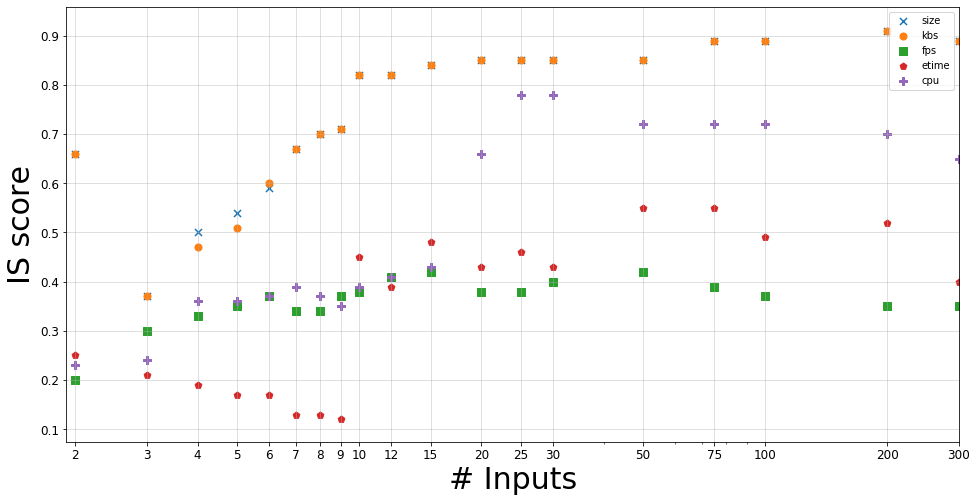

In [9]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

plt.grid(alpha=0.5)

markers = ['x', 'o', 's', 'p', 'P']

for i in range(len(inputs_perf["x264"])):
    perf = inputs_perf["x264"][i]
    ax.scatter(nb_inputs, [scores[perf, nb_inp] for nb_inp in nb_inputs], 
               label = perf, marker=markers[i], s = 50)

ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.set_xticks(nb_inputs, minor= False)

plt.xlim(1.9, 300)
plt.ylabel("IS score", fontsize = 30)
plt.xlabel("# Inputs", fontsize = 30)
plt.legend(fontsize =10)
plt.show()